In [1]:
import numpy as np
np.random.seed(123)

import sys
sys.path.append('..')

from data import load
from util import plot_grid, benchmark

import matplotlib.pyplot as plt
%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
# Code from Alex
def P_M(u, m):
    """
    u: current iterate
    m: true magnitude
    """
    F_u = np.fft.fft2(u)
    F_u += (F_u == 0) # Multiply m by one for zero Fourier entries
    v0_hat = m * (F_u / np.abs(F_u))
    return np.real(np.fft.ifft2(v0_hat))

def P_Spos(u, m, D=None):
    """
    u: current iterate
    m: true magnitude
    D: support mask, None = full support
    """
    if D is None:
        return np.maximum(0, u)
    else:
        return np.maximum(0, u) * D
    
def reflect(u, p):
    """
    u: current iterate
    p: projector output
    """
    return 2 * p - u

In [3]:
def RAARobi(m, beta=0.8, steps=200, verbose=True):

    u = np.random.rand(*m.shape)
    
    for s in range(steps):
        # otherwise case idx
        nidx = reflect(u, P_M(u, m)) < 0
        # case 1
        u_new = (1 + beta) * P_M(u, m) - u # P_M(u, m)
        # case 2
        u_new[nidx]= (1 - beta) * u[nidx] # beta*u[nidx]-(1-beta)*P_M(u, m)[nidx]
        u = u_new.copy()
    
    return np.real(u)

In [4]:
test_data = load(name='MNIST', path='../data/mnist/', batch_size=32)[0]['test']
batch = next(iter(test_data)).numpy()
magnitudes = np.abs(np.fft.fft2(batch[0]))
RAARobi(magnitudes, steps=1, verbose=False);

In [5]:
size = 1024
restart = 3

test_data = load(name='MNIST', path='../data/mnist/', batch_size=1024)[0]['test']
batch = next(iter(test_data)).numpy()[:size]
results = np.zeros_like(batch)
for i, image in enumerate(batch):
    if i % 100==0:
        print(i)
    magnitudes = np.abs(np.fft.fft2(image))
    res = []
    errors = []
    for _ in range(restart):
        res.append(RAARobi(magnitudes, steps=1000, verbose=False))
        errors.append(np.mean((np.abs(np.fft.fft2(res[-1]))-magnitudes)**2))
    results[i] = res[np.argmin(errors)]

0
100
200
300
400
500
600
700
800
900
1000


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


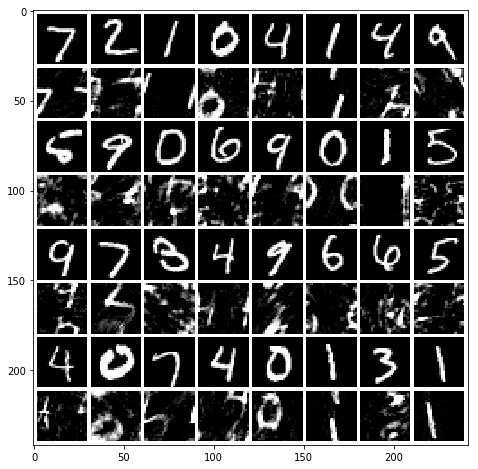

In [6]:
to_plot = np.stack([batch[:32, 0].reshape(4, 8, 28, 28), 
                    results[:32, 0].reshape(4, 8, 28, 28)], axis=1).reshape(-1, 1, 28, 28)
 
                
plot_grid(to_plot, figsize=(8,8))

In [7]:
benchmark(results, batch, check_all=True)

Signal error:
  MSE: 0.18933970923535526, std: 0.05753292109905739
  MAE: 0.2242332696187077, std: 0.06376235172726159
  SSIM: 0.10992177463538005, std: 0.1328389218212484
  Sharpness: 0.16042166049716328, std: 0.058805727254273715
  PhCo-MSE: 0.07667049954199001, std: 0.04717631308001733
  PhCo-MAE: 0.12246327403090618, std: 0.05770611795061685
  PhCo-SSIM: 0.4911806457064711, std: 0.22424633456512125
  CroCo-MSE: 0.05981467559666953, std: 0.03269757181404404
  CroCo-MAE: 0.1071735356104, std: 0.04654489394587206
  CroCo-SSIM: 0.5535259617046387, std: 0.18645834656056298

Magnitude error:
  MSE Magnitude: 1.4108451559454243, std: 1.0181490813390481

Image constraints:
  Imag part = 0.0 - should be very close to 0
  Real part is in [-0.00, 4.05] - should be in [0, 1]

Markdown table values:
 0.1893 | 0.2242 | 0.1099 | 0.1604 | 0.07667 | 0.1225 | 0.4912 | 0.05981 | 0.1072 | 0.5535 | 1.411 |


| steps | restarts | MSE | MAE | SSIM | Sharpness | PhCo-MSE | PhCo-MAE | PhCo-SSIM | CroCo-MSE | CroCo-MAE | CroCo-SSIM | MSE Magn |
| --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- |
| 1000 | 3 | 0.1703 | 0.2242 | 0.08515 | 0.1510 | 0.06233 | 0.1217 | 0.4775 | 0.04977 | 0.1097 | 0.5296 | 1.132 |